<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500,>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [29]:
data = pd.read_csv("./data/apples_pears.csv")

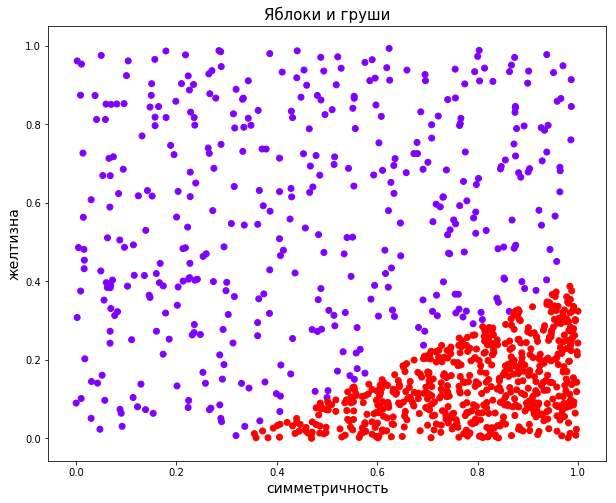

In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [31]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [32]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [33]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [34]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [35]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.6039], grad_fn=<SigmoidBackward>)

Предскажем ещё необученным нейроном:

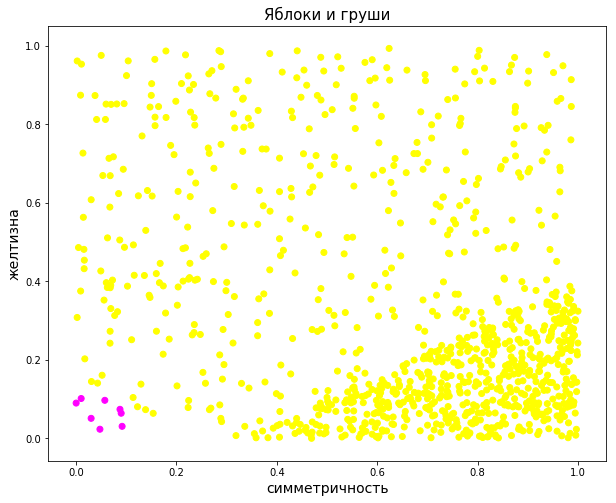

In [36]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [37]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [38]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0 255.60357666015625
1 249.90162658691406
2 244.84300231933594
3 240.24432373046875
4 235.9776611328125
5 231.95565795898438
6 228.11952209472656
7 224.43026733398438
8 220.86233520507812
9 217.39923095703125
10 214.0304412841797
11 210.74932861328125
12 207.55172729492188
13 204.4349822998047
14 201.39732360839844
15 198.4374237060547
16 195.55416870117188
17 192.74655151367188
18 190.01345825195312
19 187.3537139892578
20 184.76608276367188
21 182.24917602539062
22 179.801513671875
23 177.42156982421875
24 175.10772705078125
25 172.85830688476562
26 170.67160034179688
27 168.5458984375
28 166.47943115234375
29 164.47048950195312
30 162.51731872558594
31 160.6182098388672
32 158.77145385742188
33 156.9753875732422
34 155.2283935546875
35 153.52883911132812
36 151.8751678466797
37 150.265869140625
38 148.69944763183594
39 147.1744842529297
40 145.68954467773438
41 144.24331665039062
42 142.83447265625
43 141.4617462158203
44 140.12391662597656
45 138.81980895996094
46 137.5482788085937

439 52.8081169128418
440 52.7630615234375
441 52.71815490722656
442 52.673404693603516
443 52.62880325317383
444 52.584354400634766
445 52.54005432128906
446 52.49590301513672
447 52.451900482177734
448 52.40804672241211
449 52.36433792114258
450 52.32077407836914
451 52.27735900878906
452 52.23408508300781
453 52.190956115722656
454 52.14796829223633
455 52.10512161254883
456 52.06241989135742
457 52.01985549926758
458 51.9774284362793
459 51.935142517089844
460 51.89299392700195
461 51.850982666015625
462 51.809104919433594
463 51.767364501953125
464 51.72576141357422
465 51.684288024902344
466 51.64295196533203
467 51.60174560546875
468 51.560672760009766
469 51.51972961425781
470 51.47891616821289
471 51.438236236572266
472 51.39768600463867
473 51.35725784301758
474 51.316959381103516
475 51.276790618896484
476 51.23674774169922
477 51.19682693481445
478 51.15703201293945
479 51.11736297607422
480 51.077816009521484
481 51.03839111328125
482 50.99909210205078
483 50.95991516113281

Обучили. Предскажем теперь:

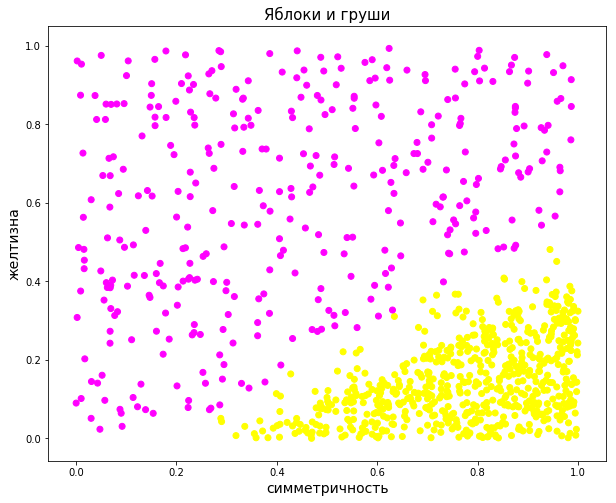

In [39]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [44]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

dtype=torch.long
# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.15  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0 9.892708778381348
1 6.135110855102539
2 6.113509178161621
3 6.081697463989258
4 6.0703277587890625
5 6.0580854415893555
6 6.051967620849609
7 6.04631233215332
8 6.042656421661377
9 6.039404392242432
10 6.03684663772583
11 6.034510135650635
12 6.032426357269287
13 6.030449867248535
14 6.028569221496582
15 6.02673864364624
16 6.02494478225708
17 6.023175239562988
18 6.021421909332275
19 6.01967716217041
20 6.017941951751709
21 6.01621150970459
22 6.0144877433776855
23 6.012767314910889
24 6.011049747467041
25 6.009334564208984
26 6.007620811462402
27 6.0059099197387695
28 6.004202365875244
29 6.002496242523193
30 6.000791072845459
31 5.999088764190674
32 5.997389316558838
33 5.995692729949951
34 5.99399471282959
35 5.992300987243652
36 5.990606784820557
37 5.988916397094727
38 5.9872260093688965
39 5.985538005828857
40 5.983851909637451
41 5.982168674468994
42 5.980485439300537
43 5.978803634643555
44 5.9771246910095215
45 5.975446701049805
46 5.9737701416015625
47 5.972095966339111
48

415 5.441697120666504
416 5.440451145172119
417 5.439206600189209
418 5.437963485717773
419 5.436721324920654
420 5.435478687286377
421 5.434238433837891
422 5.432997703552246
423 5.431760787963867
424 5.4305219650268555
425 5.42928409576416
426 5.428048610687256
427 5.42681360244751
428 5.425577163696289
429 5.424344539642334
430 5.423112392425537
431 5.421880722045898
432 5.42064905166626
433 5.419419288635254
434 5.4181904792785645
435 5.416961669921875
436 5.415735244750977
437 5.4145073890686035
438 5.41328239440918
439 5.412058353424072
440 5.410833358764648
441 5.409610748291016
442 5.408388137817383
443 5.407167434692383
444 5.405945777893066
445 5.404726028442383
446 5.403507709503174
447 5.402291297912598
448 5.401072978973389
449 5.399856090545654
450 5.398642063140869
451 5.397427558898926
452 5.396214485168457
453 5.395001411437988
454 5.393790245056152
455 5.392579555511475
456 5.3913679122924805
457 5.390160083770752
458 5.388952732086182
459 5.387743949890137
460 5.3865

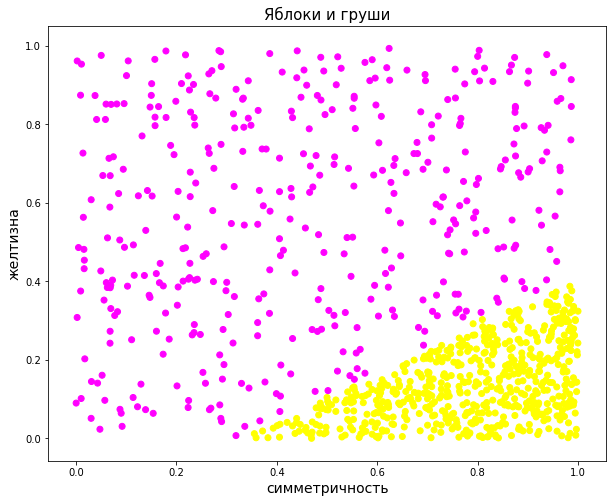

In [45]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

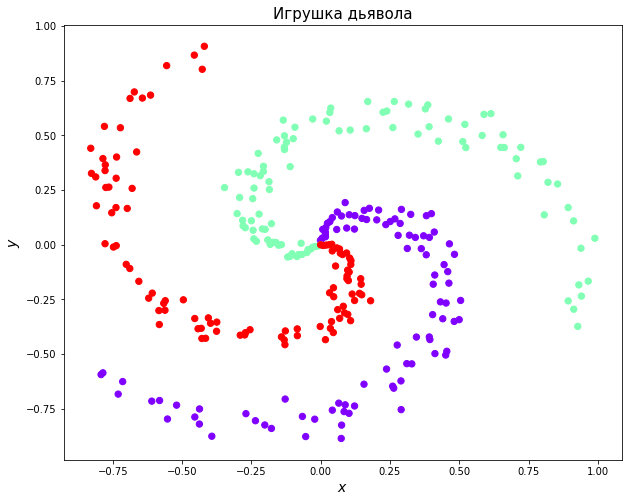

In [48]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable() (без этого градиенты не посчитать):

In [49]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [50]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [51]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

/home/scarlet/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 374.14263916015625
1 373.523681640625
2 372.90948486328125
3 372.2999267578125
4 371.69512939453125
5 371.0953063964844
6 370.50006103515625
7 369.9093017578125
8 369.3233337402344
9 368.7417297363281
10 368.1645812988281
11 367.5918884277344
12 367.0235900878906
13 366.4598693847656
14 365.900390625
15 365.3450012207031
16 364.7939758300781
17 364.2467041015625
18 363.70428466796875
19 363.1654357910156
20 362.6309509277344
21 362.1001892089844
22 361.57373046875
23 361.0512390136719
24 360.5322265625
25 360.0171203613281
26 359.5060119628906
27 358.9986267089844
28 358.4950256347656
29 357.9952087402344
30 357.4986877441406
31 357.0060729980469
32 356.516845703125
33 356.0314025878906
34 355.5493469238281
35 355.0707702636719
36 354.5954284667969
37 354.123779296875
38 353.6555480957031
39 353.1902770996094
40 352.728515625
41 352.269775390625
42 351.8144226074219
43 351.3621826171875
44 350.9131774902344
45 350.46728515625
46 350.02447509765625
47 349.5846252441406
48 349.14776611

In [52]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

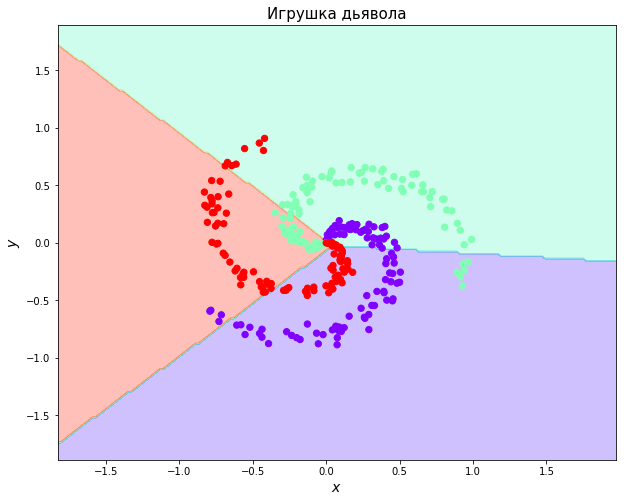

In [53]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

In [0]:
# Ваш код здесь (можно (и нужно) создавать несколько ячеек)

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*